# ExCAPE DB

- https://solr.ideaconsult.net/search/excape/?search=TP53
- https://apps.ideaconsult.net/excape

In [185]:
import pandas as pd
import json
import urllib3
import os, datetime
import seaborn as sns
from urllib.parse import urlencode

urllib3.disable_warnings()
import logging
from logging.config import fileConfig
fileConfig('logging_config.ini')
global logger
logger = logging.getLogger()
logger.debug('Started at %s \t%s',os.name, datetime.datetime.now())



2018-09-17 11:47:14,466  DEBUG    Started at nt 	2018-09-17 11:47:14.466422


In [181]:
httpmanager = urllib3.PoolManager()

In [135]:

def getSolrQuery(q,url='https://solr.ideaconsult.net/solr/excape_shard1_replica1/select'):

    fl = "type_s:\"study\",s_uuid,name:s_uuid,doc_uuid:id,topcategory:\"TOX\",endpointcategory:DB,guidance:Gene_Symbol,name:s_uuid,publicname:Original_Entry_ID,reference:Original_Assay_ID,reference_owner:DB,reference_year:\"2016\",content:\"\",owner_name:DB,loValue:pXC50,owner_name:\"ExCAPE\",substanceType:DB,Tax_ID,Entrez_ID,effectendpoint:\"pXC50\",interpretation_result:Activity_Flag,unit:\"\""
    
    query = {
        'url' :  url,
        'fl': fl,
        'fq': "{!collapse field=s_uuid}",
        'q': q
        }
    #y = json.loads(x)
    return query

def sendSolrRequest(httpmanager,query,nrows=100):
        rows=[]
        logger= logging.getLogger()

        logger.info("Sending query to %s",query['url'])
        result = httpmanager.request('GET', query['url'],
                fields={"q":query['q'], "fl" : query['fl'], "rows": 100000, "fq" : query['fq'],  "expand": "true",
                        "expand.rows": 1000, "rows": nrows,"wt": "json","json.nl": "map"},
                headers={
                 #'Accept': 'application/json'
                 }                
                 )
        logger.info("Status %s",result.status)
        data = json.loads(result.data.decode('utf-8'))
        if (result.status==200):
            #display(data)
            logger.info('Received response found {:d} docs {:d}'.format(data['response']['numFound'],len(data['response']['docs'])))
   
            #logger.debug(json.dumps(data, indent=2))
            print("parseSolrRequest")
            try:
                return parseSolrRequest(docs=data['response']['docs'],rows=rows)    
            except Exception as err:
                print(err)

        else:
            logger.error("Status %s",result.status)
            logger.debug(data)
        return rows   
    
def parseSolrRequest(docs,rows):    
    for doc in docs:
        #logger.info(json.dumps(doc, indent=2))
        #print(type(doc))
        rows.append(doc)
    return rows

def getCompound_json(http,inchikey,ambit_url="https://apps.ideaconsult.net/excape"):
        logger= logging.getLogger()
        #url = (ambit_url + "/query/compound/search/all?search=" + substance_uuid + "&media=application/json")
        url = '{}/query/compound/inchikey/all?search={}&media=application/json'.format(ambit_url,inchikey)
        result = http.request('GET', url )
        #logger.debug(url)        
        if (result.status==200):
            compound = json.loads(result.data.decode('utf-8'))
            return compound
        else:
            logger.error(result.status)
            return None
        
def getCompound_mol(http,inchikey,ambit_url="https://apps.ideaconsult.net/excape"):
        logger= logging.getLogger()
        params = urlencode({ "search" : inchikey, "media" : "chemical/x-mdl-sdfile"})
        url = ('{}/query/compound/inchikey/all'.format(ambit_url) + "?" +  params)
        
        result = http.request('GET', url )
        if (result.status==200):
            return result.data.decode("utf-8") 
        else:
            logger.error(result.status)
            return None        
        
def getCompound_similarity(http,query,ambit_url="https://apps.ideaconsult.net/excape", threshold=0.8 , media="chemical/x-mdl-sdfile", page=0, pagesize=10):
        logger= logging.getLogger()
        params = urlencode({ "search" : query,"type": "auto", "threshold" : threshold, "media" :media, "page" : page, "pagesize" : pagesize})

        url = ('{}/query/similarity'.format(ambit_url) + "?" +  params)
        
        result = http.request('GET', url )
        if (result.status==200):
            return result.data.decode("utf-8") 
        else:
            logger.error(result.status)
            return None        

In [136]:
query = getSolrQuery('TP53')
logger.info(query)

2018-09-17 09:48:36,201  INFO     {'url': 'https://solr.ideaconsult.net/solr/excape_shard1_replica1/select', 'fl': 'type_s:"study",s_uuid,name:s_uuid,doc_uuid:id,topcategory:"TOX",endpointcategory:DB,guidance:Gene_Symbol,name:s_uuid,publicname:Original_Entry_ID,reference:Original_Assay_ID,reference_owner:DB,reference_year:"2016",content:"",owner_name:DB,loValue:pXC50,owner_name:"ExCAPE",substanceType:DB,Tax_ID,Entrez_ID,effectendpoint:"pXC50",interpretation_result:Activity_Flag,unit:""', 'fq': '{!collapse field=s_uuid}', 'q': 'TP53'}


In [137]:
rows=sendSolrRequest(httpmanager,query,nrows=100000)

2018-09-17 09:48:36,684  INFO     Sending query to https://solr.ideaconsult.net/solr/excape_shard1_replica1/select
2018-09-17 09:50:16,075  INFO     Status 200
2018-09-17 09:50:16,831  INFO     Received response found 388890 docs 100000


parseSolrRequest


In [138]:
df = pd.DataFrame(rows)

In [139]:
(df.head())

,Entrez_ID,Tax_ID,content,doc_uuid,effectendpoint,endpointcategory,guidance,interpretation_result,loValue,name,owner_name,publicname,reference,reference_owner,reference_year,s_uuid,substanceType,topcategory,type_s,unit
0,7157,9606,,449e4133-9160-4bf9-bcd3-5655facb9c63,pXC50,pubchem,TP53,N,NaN,BGHCVCJVXZWKCC-UHFFFAOYNA-N,pubchem,12389,651631,pubchem,2016,BGHCVCJVXZWKCC-UHFFFAOYNA-N,pubchem,TOX,study,
1,7157,9606,,cdf2b1ef-e61f-4437-b56f-c6e22ae34b3d,pXC50,pubchem,TP53,N,NaN,BFDNZQUBFCYTIC-UHFFFAOYNA-N,pubchem,13000,651631,pubchem,2016,BFDNZQUBFCYTIC-UHFFFAOYNA-N,pubchem,TOX,study,
2,7157,9606,,457a5860-b210-4793-8528-83ed5a08a848,pXC50,pubchem,TP53,N,NaN,COBPKKZHLDDMTB-UHFFFAOYNA-N,pubchem,8923,651743,pubchem,2016,COBPKKZHLDDMTB-UHFFFAOYNA-N,pubchem,TOX,study,
3,7157,9606,,65de4a1f-5caf-485e-8140-e2a1333e0a3a,pXC50,pubchem,TP53,N,NaN,MDAXKAUIABOHTD-UHFFFAOYNA-N,pubchem,64964,504706,pubchem,2016,MDAXKAUIABOHTD-UHFFFAOYNA-N,pubchem,TOX,study,
4,7157,9606,,425ae9cc-f789-400d-80ab-e3f6393aa66d,pXC50,pubchem,TP53,N,NaN,JVGPVVUTUMQJKL-UHFFFAOYNA-N,pubchem,8196,924,pubchem,2016,JVGPVVUTUMQJKL-UHFFFAOYNA-N,pubchem,TOX,study,


In [140]:
(df.shape)

(100000, 20)

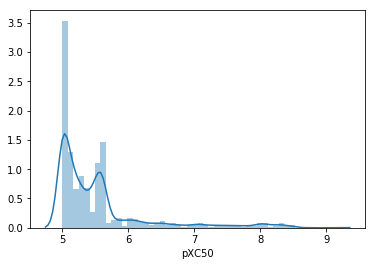

In [141]:
actives = df.loc[df['interpretation_result']=='A']
ax=sns.distplot(actives['loValue'], axlabel="pXC50")

In [142]:
mol=getCompound_mol(http,inchikey="BGHCVCJVXZWKCC-UHFFFAOYNA-N")

In [143]:
(mol)

'\n  CDK     0917180950\n\n 14 13  0  0  0  0  0  0  0  0999 V2000\n    0.0000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.0000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.0000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.0000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.0000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.0000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.0000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.0000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.0000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.0000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.0000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.0000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.0000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.000

In [172]:
dataset = getCompound_json(http,inchikey="BGHCVCJVXZWKCC-UHFFFAOYNA-N")


2018-09-17 11:51:28,986  DEBUG    STREAM b'IHDR' 16 13
2018-09-17 11:51:28,987  DEBUG    STREAM b'IDAT' 41 901


InChI=1/C14H30/c1-3-5-7-9-11-13-14-12-10-8-6-4-2/h3-14H2,1-2H3
https://apps.ideaconsult.net/excape/compound/68503


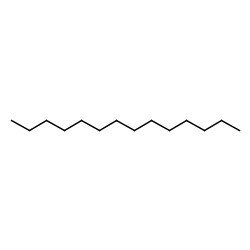

In [196]:
from PIL import Image
import urllib.request
import io
for data_entry in dataset['dataEntry']:
    print(data_entry['compound']['inchi'])
    url = data_entry['compound']['URI']
    print(url)

    im = urllib.request.urlopen('{}?media=image/png'.format(url))
    image_file = io.BytesIO(im.read())
    display(Image.open(image_file))


## Similarity search demo

In [146]:
#retrieve SDF
dataset = getCompound_similarity(http,query="c1ccccc1CCCCCC",threshold=0.85, media="chemical/x-mdl-sdfile", pagesize=2)
print(dataset)


  CDK     0917180950

 18 18  0  0  0  0  0  0  0  0999 V2000
    0.0000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.0000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.0000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.0000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.0000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.0000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.0000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.0000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.0000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.0000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.0000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.0000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.0000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.0000    0.0000    0.0

In [147]:
#retrieve CSV
dataset = getCompound_similarity(http,query="c1ccccc1CCCCCC",threshold=0.85, media="text/csv", pagesize=2)
print(dataset)
#for data_entry in dataset['dataEntry']:

Compound,"http://www.opentox.org/api/1.1#CASRN ","http://www.opentox.org/api/1.1#EINECS ","http://www.opentox.org/api/1.1#ChemicalName ","http://www.opentox.org/api/1.1#TradeName ","http://www.opentox.org/api/1.1#IUPACName ","http://www.opentox.org/api/1.1#IUCLID5_UUID ","http://www.opentox.org/api/1.1#SMILES ","http://www.opentox.org/api/1.1#InChI_std ","http://www.opentox.org/api/1.1#InChIKey_std ","metric ",SMILES
https://apps.ideaconsult.net/excape/compound/539075/conformer/1915182,"","","","","","","C(CCCCCC1=CC=CC=C1)CCCCCC","InChI=1/C18H30/c1-2-3-4-5-6-7-8-9-10-12-15-18-16-13-11-14-17-18/h11,13-14,16-17H,2-10,12,15H2,1H3","KWKXNDCHNDYVRT-UHFFFAOYNA-N","0.92",
https://apps.ideaconsult.net/excape/compound/565257/conformer/1941364,"","","","","","","C(CCCCC)CCCC1=CC=CC=C1","InChI=1/C15H24/c1-2-3-4-5-6-7-9-12-15-13-10-8-11-14-15/h8,10-11,13-14H,2-7,9,12H2,1H3","LIXVMPBOGDCSRM-UHFFFAOYNA-N","0.92",



In [168]:
#retrieve JSON
data_j = getCompound_similarity(http,query="C(CCCCCC1=CC=CC=C1)CCCCCC",threshold=0.85, media="application/json", pagesize=2)
compound = json.loads(data_j)
for data_entry in compound['dataEntry']:
    print(data_entry)
    uri = data_entry['compound']['URI']
    inchikey = data_entry['values']['https://apps.ideaconsult.net/excape/feature/http%3A%2F%2Fwww.opentox.org%2Fapi%2F1.1%23InChIKey_stdDefault']
    logger.info('{} {}\n'.format(inchikey,uri))
    query = getSolrQuery(q=inchikey)
    logger.info('ExCAPE DB query for %s',query['q'])
    excabedb_values = sendSolrRequest(httpmanager,query,nrows=1)
    display(pd.DataFrame(excabedb_values).head())

2018-09-17 10:00:53,066  INFO     KWKXNDCHNDYVRT-UHFFFAOYNA-N https://apps.ideaconsult.net/excape/compound/539075/conformer/1915182

2018-09-17 10:00:53,067  INFO     ExCAPE DB query for KWKXNDCHNDYVRT-UHFFFAOYNA-N
2018-09-17 10:00:53,068  INFO     Sending query to https://solr.ideaconsult.net/solr/excape_shard1_replica1/select
2018-09-17 10:00:53,121  INFO     Status 200
2018-09-17 10:00:53,122  INFO     Received response found 997982 docs 1


{'compound': {'URI': 'https://apps.ideaconsult.net/excape/compound/539075/conformer/1915182', 'structype': 'D1', 'metric': 1.0, 'name': '', 'cas': '', 'einecs': ''}, 'values': {'https://apps.ideaconsult.net/excape/feature/http%3A%2F%2Fwww.opentox.org%2Fapi%2F1.1%23SMILESDefault': 'C(CCCCCC1=CC=CC=C1)CCCCCC', 'https://apps.ideaconsult.net/excape/feature/http%3A%2F%2Fwww.opentox.org%2Fapi%2F1.1%23InChI_stdDefault': 'InChI=1/C18H30/c1-2-3-4-5-6-7-8-9-10-12-15-18-16-13-11-14-17-18/h11,13-14,16-17H,2-10,12,15H2,1H3', 'https://apps.ideaconsult.net/excape/feature/http%3A%2F%2Fwww.opentox.org%2Fapi%2F1.1%23InChIKey_stdDefault': 'KWKXNDCHNDYVRT-UHFFFAOYNA-N'}, 'facets': [], 'bundles': {}}
parseSolrRequest


,Entrez_ID,Tax_ID,content,doc_uuid,effectendpoint,endpointcategory,guidance,interpretation_result,name,owner_name,publicname,reference,reference_owner,reference_year,s_uuid,substanceType,topcategory,type_s,unit
0,1588,9606,,85c06f4c-3768-4f19-bf4c-6917abf8c622,pXC50,pubchem,CYP19A1,N,KWKXNDCHNDYVRT-UHFFFAOYNA-N,pubchem,31237,743083,pubchem,2016,KWKXNDCHNDYVRT-UHFFFAOYNA-N,pubchem,TOX,study,


2018-09-17 10:00:53,151  INFO     LIXVMPBOGDCSRM-UHFFFAOYNA-N https://apps.ideaconsult.net/excape/compound/565257/conformer/1941364

2018-09-17 10:00:53,152  INFO     ExCAPE DB query for LIXVMPBOGDCSRM-UHFFFAOYNA-N
2018-09-17 10:00:53,154  INFO     Sending query to https://solr.ideaconsult.net/solr/excape_shard1_replica1/select
2018-09-17 10:00:53,174  INFO     Status 200
2018-09-17 10:00:53,176  INFO     Received response found 997982 docs 1


{'compound': {'URI': 'https://apps.ideaconsult.net/excape/compound/565257/conformer/1941364', 'structype': 'D1', 'metric': 1.0, 'name': '', 'cas': '', 'einecs': ''}, 'values': {'https://apps.ideaconsult.net/excape/feature/http%3A%2F%2Fwww.opentox.org%2Fapi%2F1.1%23SMILESDefault': 'C(CCCCC)CCCC1=CC=CC=C1', 'https://apps.ideaconsult.net/excape/feature/http%3A%2F%2Fwww.opentox.org%2Fapi%2F1.1%23InChI_stdDefault': 'InChI=1/C15H24/c1-2-3-4-5-6-7-9-12-15-13-10-8-11-14-15/h8,10-11,13-14H,2-7,9,12H2,1H3', 'https://apps.ideaconsult.net/excape/feature/http%3A%2F%2Fwww.opentox.org%2Fapi%2F1.1%23InChIKey_stdDefault': 'LIXVMPBOGDCSRM-UHFFFAOYNA-N'}, 'facets': [], 'bundles': {}}
parseSolrRequest


,Entrez_ID,Tax_ID,content,doc_uuid,effectendpoint,endpointcategory,guidance,interpretation_result,name,owner_name,publicname,reference,reference_owner,reference_year,s_uuid,substanceType,topcategory,type_s,unit
0,196,9606,,55880fe2-871f-4315-9ceb-cfd5e28dc737,pXC50,pubchem,AHR,N,LIXVMPBOGDCSRM-UHFFFAOYNA-N,pubchem,14126,651777,pubchem,2016,LIXVMPBOGDCSRM-UHFFFAOYNA-N,pubchem,TOX,study,


### That's all.

More info on AMBIT at http://ambit.sourceforge.net/ 
Example client code https://github.com/ideaconsult/apps-ambit